## Time Series Analysis of Litecoin Cryptocurrency in Python

Shpaner, Leonid - March 11, 2022

The following time series analysis is an update to the pre-existing analysis conducted in R, but this time done in Python. The data is sourced from Yahoo Finance.

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ltc = yf.download('LTC-USD', start ='2011-01-01', 
                             end='2022-03-10', 
                             progress=False)

In [3]:
ltc.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,5.08589,5.17077,4.96595,5.05855,5.05855,3071840
2014-09-18,5.06543,5.06543,4.57996,4.68523,4.68523,4569260
2014-09-19,4.68729,4.75582,4.25435,4.32777,4.32777,3917450
2014-09-20,4.32920,4.61608,4.20219,4.28644,4.28644,5490660
2014-09-21,4.26307,4.30013,4.15499,4.24592,4.24592,2931220


### Simple Returns
Simple returns are aggregated over assets, which is a "weighted sum of the returns of the individual assests in the portfolio" (Lewinson, 2020).

$$R_t = \frac{(P_t-P_{t-1})}{P_{t-1}} = \frac{P_t}{P_{t-1}}-1$$

### Log Returns

Log returns are aggregated over time.

$$r_t = log\left(\frac{P_t}{P_{t-1}}\right) = log(P_t) - log(P_t-1)$$

In [4]:
ltc.rename(columns = {'Adj Close': 'adj_close'}, inplace=True)
ltc['simple_rtn'] = ltc.adj_close.pct_change()
ltc['log_rtn'] = np.log(ltc.adj_close/ltc.adj_close.shift(1))

In [5]:
ltc.head()

,Open,High,Low,Close,adj_close,Volume,simple_rtn,log_rtn
Date,,,,,,,,
2014-09-17,5.08589,5.17077,4.96595,5.05855,5.05855,3071840,NaN,NaN
2014-09-18,5.06543,5.06543,4.57996,4.68523,4.68523,4569260,-0.073800,-0.076665
2014-09-19,4.68729,4.75582,4.25435,4.32777,4.32777,3917450,-0.076295,-0.079363
2014-09-20,4.32920,4.61608,4.20219,4.28644,4.28644,5490660,-0.009550,-0.009596
2014-09-21,4.26307,4.30013,4.15499,4.24592,4.24592,2931220,-0.009453,-0.009498


In [6]:
ltc.head()
# ltc['Date'] = pd.to_datetime(ltc['Date'])

,Open,High,Low,Close,adj_close,Volume,simple_rtn,log_rtn
Date,,,,,,,,
2014-09-17,5.08589,5.17077,4.96595,5.05855,5.05855,3071840,NaN,NaN
2014-09-18,5.06543,5.06543,4.57996,4.68523,4.68523,4569260,-0.073800,-0.076665
2014-09-19,4.68729,4.75582,4.25435,4.32777,4.32777,3917450,-0.076295,-0.079363
2014-09-20,4.32920,4.61608,4.20219,4.28644,4.28644,5490660,-0.009550,-0.009596
2014-09-21,4.26307,4.30013,4.15499,4.24592,4.24592,2931220,-0.009453,-0.009498


In [7]:
print('Number of Rows:', ltc.shape[0])
print('Number of Columns:', ltc.shape[1], '\n')

data_types = ltc.dtypes
data_types = pd.DataFrame(data_types)
data_types = data_types.assign(Null_Values = 
                               ltc.isnull().sum())
data_types.reset_index(inplace = True)
data_types.rename(columns={0:'Data Type',
                          'index': 'Column/Variable',
                          'Null_Values': "# of Nulls"})

Number of Rows: 2732
Number of Columns: 8 



,Column/Variable,Data Type,# of Nulls
0,Open,float64,0
1,High,float64,0
2,Low,float64,0
3,Close,float64,0
4,adj_close,float64,0
5,Volume,int64,0
6,simple_rtn,float64,1
7,log_rtn,float64,1


Below, litecoin's historical prices (2015 - Present), simple returns, and log returns, respectively, are shown.

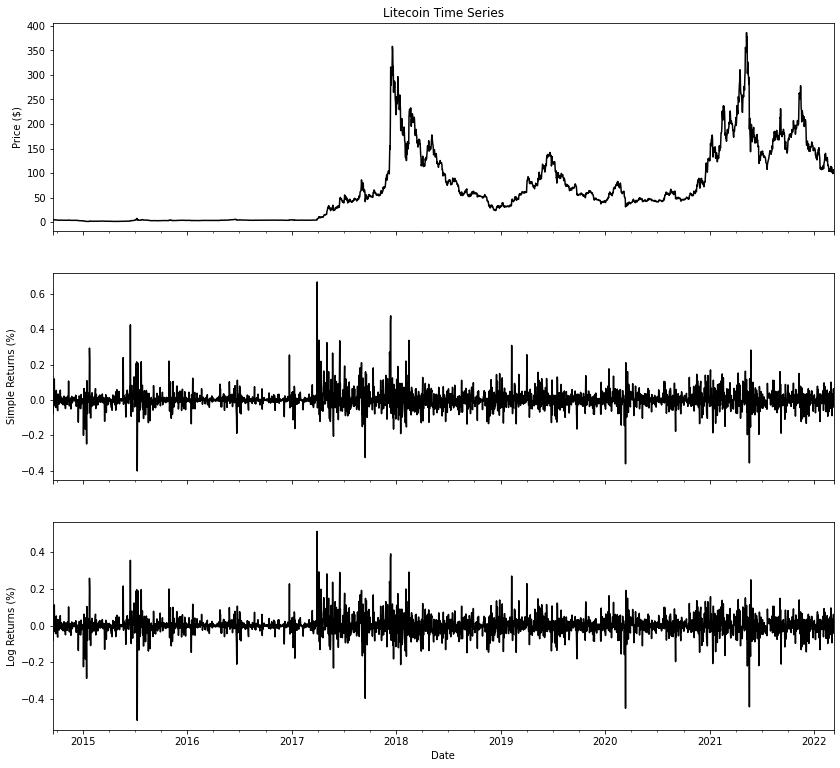

In [8]:
fig, ax = plt.subplots(3,1,figsize=(14,13), sharex = True)
ltc.adj_close.plot(ax=ax[0], color = 'black')
ax[0].set(title = 'Litecoin Time Series', ylabel = 'Price ($)')
ltc.simple_rtn.plot(ax=ax[1], color = 'black')
ax[1].set(xlabel = 'Date', ylabel = 'Simple Returns (%)')
ltc.log_rtn.plot(ax=ax[2], color = 'black')
ax[2].set(xlabel = 'Date', ylabel = 'Log Returns (%)')
plt.show()

### Outliers

Outliers are identifying within 3 standard deviations from the mean in order to avoid biased estimates/ingesting unecessary noise into the modeling framework.

The rolling mean and standard deviation are thus calculated.

In [9]:
ltc_rolling = ltc[['simple_rtn']].rolling(window=21).agg(['mean', 'std'])
ltc_rolling.columns = ltc_rolling.columns.droplevel()
ltc_outliers = ltc.join(ltc_rolling)

# detect outliers
def outliers_ltc (row, n_sigmas=3):
    x = row['simple_rtn']
    mu = row['mean']
    sigma = row['std']
    if (x > mu + 3 * sigma) | (x < mu - 3 * sigma):
        return 1
    else:
        return 0

ltc_outliers['outlier'] = ltc_outliers.apply(outliers_ltc,
axis=1)
outliers = ltc_outliers.loc[ltc_outliers['outlier'] == 1,['simple_rtn']]

### Outlier Plot

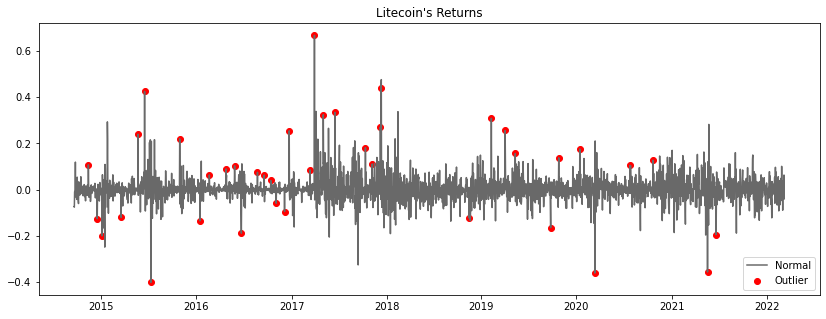

In [10]:
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(ltc_outliers.index, ltc_outliers.simple_rtn,
color='dimgrey', label='Normal')
ax.scatter(outliers.index, outliers.simple_rtn,
color='red', label='Outlier')
ax.set_title("Litecoin's Returns")
ax.legend(loc='lower right')
plt.show()

### Visualizing Returns Via Distributions

In [11]:
ltc1 = ltc[['adj_close', 'log_rtn']].dropna(how = 'any')

In [12]:
# probability density function 
r_range = np.linspace(min(ltc1.log_rtn), max(ltc1.log_rtn), num=1000)
mu = ltc1.log_rtn.mean()
sigma = ltc1.log_rtn.std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)

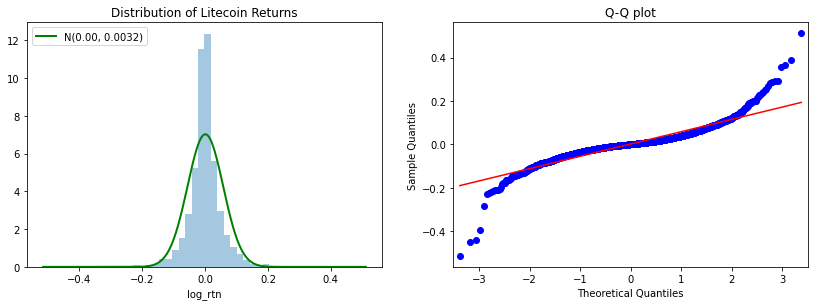

---------- Descriptive Statistics ----------
Range of dates: 2014-09-18 - 2022-03-10
Number of observations: 2731
Mean: 0.0011
Median: -0.0003
Min: -0.5146
Max: 0.5114
Standard Deviation: 0.0568
Skewness: 0.1153
Kurtosis: 12.9461
Jarque-Bera statistic: 19001.57 with p-value: 0.00


In [13]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4.5))
# histogram
sns.distplot(ltc1.log_rtn, kde=False, norm_hist=True, ax=ax[0])
ax[0].set_title('Distribution of Litecoin Returns')
ax[0].plot(r_range, norm_pdf, 'g', lw=2,
label=f'N({mu:.2f}, {sigma**2:.4f})')
ax[0].legend(loc='upper left')

# Q-Q plot
qq = sm.qqplot(ltc1.log_rtn.values, line='s', ax=ax[1])
ax[1].set_title('Q-Q plot')
plt.show()

jb_test = scs.jarque_bera(ltc1.log_rtn.values)
print('---------- Descriptive Statistics ----------')
print('Range of dates:', min(ltc1.index.date), '-', max(ltc1.index.date))
print('Number of observations:', ltc1.shape[0])
print(f'Mean: {ltc1.log_rtn.mean():.4f}')
print(f'Median: {ltc1.log_rtn.median():.4f}')
print(f'Min: {ltc1.log_rtn.min():.4f}')
print(f'Max: {ltc1.log_rtn.max():.4f}')
print(f'Standard Deviation: {ltc1.log_rtn.std():.4f}')
print(f'Skewness: {ltc1.log_rtn.skew():.4f}')
print(f'Kurtosis: {ltc1.log_rtn.kurtosis():.4f}') 
print(f'Jarque-Bera statistic: {jb_test[0]:.2f} with p-value: {jb_test[1]:.2f}')